In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import the libraries and saved variables

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [14]:
import joblib
import os

# --- 1. Define the path where you want to save the variables ---
# It's good practice to create a dedicated folder in your Drive.
save_path = '/content/drive/MyDrive/colab_project_state/'
os.makedirs(save_path, exist_ok=True) # Create the directory if it doesn't exist

# --- 2. Bundle all important variables into a single dictionary ---
# This makes saving and loading much cleaner.
session_variables = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test,
    'all_results': all_results,
    'tokenizer': tokenizer
}

# --- 3. Save the dictionary to a file using joblib ---
file_path = os.path.join(save_path, 'phishing_session.pkl')
joblib.dump(session_variables, file_path)

print(f"All session variables successfully saved to: {file_path}")


All session variables successfully saved to: /content/drive/MyDrive/colab_project_state/phishing_session.pkl


In [11]:
import joblib
import os

# --- 1. Define the path where your variables are saved ---
save_path = '/content/drive/MyDrive/colab_project_state/'
file_path = os.path.join(save_path, 'phishing_session.pkl')

# --- 2. Load the dictionary from the file ---
try:
    loaded_vars = joblib.load(file_path)

    # --- 3. Unpack the dictionary back into your notebook's global variables ---
    X_train = loaded_vars['X_train']
    y_train = loaded_vars['y_train']
    X_test = loaded_vars['X_test']
    y_test = loaded_vars['y_test']
    all_results = loaded_vars['all_results']
    tokenizer = loaded_vars['tokenizer']

    print("Session variables successfully loaded!")
    print(f"Loaded {len(X_train)} training samples.")
    print(f"Found {len(all_results)} model results in 'all_results'.")

except FileNotFoundError:
    print(f"Error: Save file not found at {file_path}. Please run the 'Save Session' block in a previous session first.")


Session variables successfully loaded!
Loaded 439476 training samples.
Found 13 model results in 'all_results'.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/paper_dataset.csv')
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


# Data Preprocessing

In [ ]:
df['Label'] = df['Label'].astype(str).str.strip().str.lower()
df = df[df['Label'].isin(['bad', 'good'])]
df['Label'] = df['Label'].map({'bad': 1, 'good': 0})
df = df.dropna(subset=['URL', 'Label'])


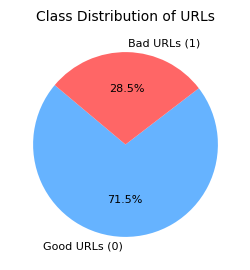

In [ ]:
# Plot class distribution pie chart
class_counts = df['Label'].value_counts()
labels = ['Good URLs (0)', 'Bad URLs (1)']
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(3, 3))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 8})
plt.title('Class Distribution of URLs', fontsize=10)
plt.show()


In [ ]:
# Separate features (URLs) and labels
texts = df['URL'].astype(str).values
labels = df['Label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# Defining model and results functions

In [ ]:
# --- Define a function for each model ---

def plot_confusion_matrix(cm, model_name):
    """Helper function to plot a confusion matrix."""
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Good', 'Predicted Bad'],
                yticklabels=['True Good', 'True Bad'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def run_model(model, model_name):
    """A generic function to run a model pipeline."""
    pipeline = Pipeline([
      ('tfidf', TfidfVectorizer(
          analyzer='char',
          ngram_range=(3, 5),
          max_features=20000  # Keep only the top 20,000 features
      )),
      ('clf', model)
    ])
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, target_names=['good (class 0)', 'bad (class 1)'], zero_division=0)
    cm = confusion_matrix(y_test, predictions)

    return {'name': model_name, 'accuracy': accuracy, 'report': report, 'confusion_matrix': cm}

# Store results for the final comparison
all_results = []


# **Machine Learning Models**



*   **XGBoost**



--- Results for: XGBoost ---
Final Test Accuracy: 0.9203

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.97      0.92      0.94     78585
 bad (class 1)       0.82      0.92      0.87     31285

      accuracy                           0.92    109870
     macro avg       0.89      0.92      0.91    109870
  weighted avg       0.93      0.92      0.92    109870



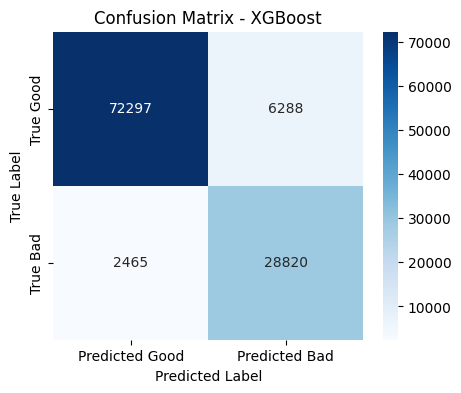

In [ ]:
# --- 1. Run and Evaluate XGBoost ---

# Note: This assumes 'scale_pos_weight' has been calculated from the training set
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Define the model instance
xgb_model = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)

# Run the evaluation
xgb_result = run_model(xgb_model, 'XGBoost')

# Append the results
all_results.append(xgb_result)

# Print the report and plot its confusion matrix
print(f"--- Results for: {xgb_result['name']} ---")
print(f"Final Test Accuracy: {xgb_result['accuracy']:.4f}\n")
print("Classification Report:")
print(xgb_result['report'])
plot_confusion_matrix(xgb_result['confusion_matrix'], xgb_result['name'])




*   **Random Forest**


--- Results for: Random Forest ---
Final Test Accuracy: 0.9252

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.95      0.94      0.95     78585
 bad (class 1)       0.86      0.88      0.87     31285

      accuracy                           0.93    109870
     macro avg       0.91      0.91      0.91    109870
  weighted avg       0.93      0.93      0.93    109870



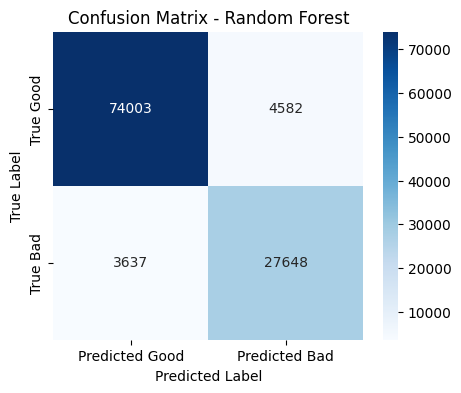

In [ ]:
# --- 2. Run and Evaluate Random Forest ---

# Define the model instance
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=50,          # Limit tree depth
    min_samples_leaf=5,    # Require at least 5 samples in a leaf
    random_state=42,
    n_jobs=-1
)

# Run the evaluation
rf_result = run_model(rf_model, 'Random Forest')

# Append the results to the list for later comparison
all_results.append(rf_result)

# Print the report and plot its confusion matrix
print(f"--- Results for: {rf_result['name']} ---")
print(f"Final Test Accuracy: {rf_result['accuracy']:.4f}\n")
print("Classification Report:")
print(rf_result['report'])
plot_confusion_matrix(rf_result['confusion_matrix'], rf_result['name'])


*   **Logistic Regression**

--- Results for: Logistic Regression ---
Final Test Accuracy: 0.9585

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.98      0.96      0.97     78585
 bad (class 1)       0.91      0.95      0.93     31285

      accuracy                           0.96    109870
     macro avg       0.94      0.96      0.95    109870
  weighted avg       0.96      0.96      0.96    109870



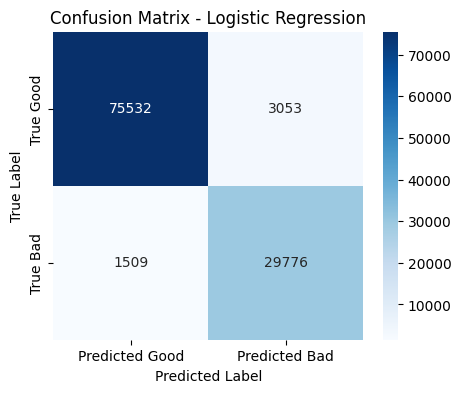

In [ ]:
# --- 3. Run and Evaluate Logistic Regression ---

# Define the model instance
lr_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

# Run the evaluation
lr_result = run_model(lr_model, 'Logistic Regression')

# Append the results
all_results.append(lr_result)

# Print the report and plot its confusion matrix
print(f"--- Results for: {lr_result['name']} ---")
print(f"Final Test Accuracy: {lr_result['accuracy']:.4f}\n")
print("Classification Report:")
print(lr_result['report'])
plot_confusion_matrix(lr_result['confusion_matrix'], lr_result['name'])




*   **Linear SVM**

'Linear SVM' results appended for comparison.

--- Results for: Linear SVM ---
Final Test Accuracy: 0.9655

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.98      0.97      0.98     78585
 bad (class 1)       0.92      0.96      0.94     31285

      accuracy                           0.97    109870
     macro avg       0.95      0.96      0.96    109870
  weighted avg       0.97      0.97      0.97    109870



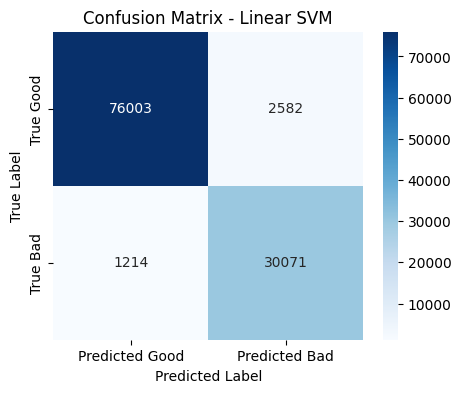

In [ ]:
# --- 4. Run and Evaluate a Linear SVM ---

# Define the model instance using LinearSVC
# Note: LinearSVC doesn't have a 'kernel' parameter because it's always linear.
svm_model = LinearSVC(class_weight='balanced', random_state=42, dual=True, max_iter=1000)

# Run the evaluation
svm_result = run_model(svm_model, 'Linear SVM')

# Append the results
all_results.append(svm_result)
print(f"'{svm_result['name']}' results appended for comparison.\n")

# Print the report and plot its confusion matrix
print(f"--- Results for: {svm_result['name']} ---")
print(f"Final Test Accuracy: {svm_result['accuracy']:.4f}\n")
print("Classification Report:")
print(svm_result['report'])
plot_confusion_matrix(svm_result['confusion_matrix'], svm_result['name'])


# Import the libraries for Deep Learning

In [2]:
# Core TensorFlow and Keras libraries for building models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,        # Turns numbers into dense vectors of fixed size.
    Conv1D,           # Operates on sequences, good for finding local patterns.
    GlobalMaxPooling1D, # Downsamples by taking the max value.
    Dense,            # A standard, fully-connected neural network layer.
    Dropout,          # A regularization technique to prevent overfitting.
    LSTM,             # The Long Short-Term Memory layer for sequence processing.
    GRU,              # The Gated Recurrent Unit layer, a simpler alternative to LSTM.
    Bidirectional,     # A wrapper that allows RNNs to process sequences in both directions.
    BatchNormalization,
    Activation
  )

# Keras utilities for text and sequence preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Standard libraries for data handling and evaluation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Data Preprocessing for DL models

In [ ]:
# Parameters
VOCAB_SIZE = 10000  # Number of unique characters to consider
MAX_LEN = 200       # Max length of a URL
EMBEDDING_DIM = 64  # Dimension of the character embedding

# Tokenize the URLs (convert characters to integers)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, char_level=True, oov_token='<UNK>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences to ensure they are all the same length
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Split the data
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    padded_sequences, labels, test_size=0.2, stratify=labels, random_state=42
)

# Defining model and results functions

In [ ]:
def train_and_evaluate_dl_model(model, model_name, epochs=5, batch_size=256):
    """
    Trains, evaluates, and reports on a given Keras model.
    """
    print(f"\n--- Training {model_name} ---")

    # Step 1: Compile the model with an optimizer, loss function, and metrics.
    # 'adam' is a great general-purpose optimizer.
    # 'binary_crossentropy' is the standard loss function for two-class problems.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Step 2: Train the model on the training data.
    # validation_split=0.1 reserves 10% of the training data to monitor performance.
    history = model.fit(
        X_train_dl, y_train_dl,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )

    print(f"\n--- Evaluating {model_name} ---")

    # Step 3: Evaluate the final model on the unseen test data.
    loss, accuracy = model.evaluate(X_test_dl, y_test_dl, verbose=0)
    print(f"\nTest Accuracy for {model_name}: {accuracy:.4f}")

    # Step 4: Get detailed predictions to generate a full report.
    y_pred_probs = model.predict(X_test_dl)
    y_pred_dl = (y_pred_probs > 0.5).astype(int) # Convert probabilities to class labels (0 or 1).

    dl_report = classification_report(y_test_dl, y_pred_dl, target_names=['good (class 0)', 'bad (class 1)'])
    dl_cm = confusion_matrix(y_test_dl, y_pred_dl)

    print("\nClassification Report:")
    print(dl_report)

    # Step 5: Package the results into a clean dictionary and return.
    result_dict = {
        'name': model_name,
        'accuracy': accuracy,
        'report': dl_report,
        'confusion_matrix': dl_cm
    }
    return result_dict

# **Deep Learning Models**



*   **Gated Recurrent Unit (GRU)**




--- Training GRU ---
Epoch 1/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.7611 - loss: 0.5253 - val_accuracy: 0.9297 - val_loss: 0.1858
Epoch 2/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.9317 - loss: 0.1824 - val_accuracy: 0.9453 - val_loss: 0.1451
Epoch 3/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.9474 - loss: 0.1441 - val_accuracy: 0.9558 - val_loss: 0.1226
Epoch 4/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.9561 - loss: 0.1209 - val_accuracy: 0.9549 - val_loss: 0.1226
Epoch 5/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.9611 - loss: 0.1087 - val_accuracy: 0.9629 - val_loss: 0.1028

--- Evaluating GRU ---

Test Accuracy for GRU: 0.9641
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.97      0.98      0.97     78585
 bad (class 1)       0.94      0.93      0.94     31285

      accuracy                

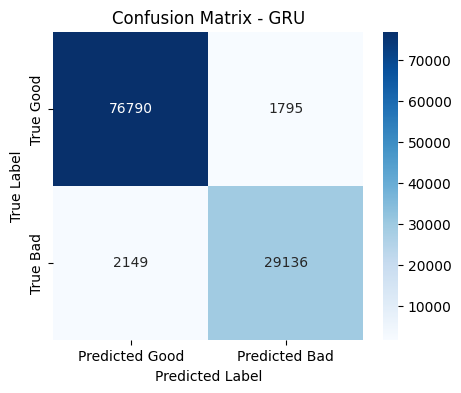

In [ ]:
# --- 1. Define the GRU Model Architecture ---
gru_model = Sequential([
    # Layer 1: Embedding. As before, this converts our character integers into meaningful
    # vector representations for the model to process.
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM),

    # Layer 2: GRU. A more streamlined recurrent layer than LSTM. It uses an 'update' and
    # a 'reset' gate to manage its memory state, making it computationally more efficient
    # while still being very effective at capturing sequential patterns.
    GRU(units=64),

    # Layer 3: Dropout. This helps prevent the model from memorizing the training data
    # by adding noise, which encourages it to learn more robust features.
    Dropout(0.5),

    # Layer 4: Dense. This layer learns non-linear combinations of the features
    # extracted by the GRU layer.
    Dense(32, activation='relu'),

    # Layer 5: Output Dense. The final sigmoid neuron that provides the probability
    # of the input URL being malicious (class 1).
    Dense(1, activation='sigmoid')
])

# --- 2. Train and Evaluate the GRU ---
gru_result = train_and_evaluate_dl_model(gru_model, "GRU")

# --- 3. Add results to master list and visualize ---
all_results.append(gru_result)
plot_confusion_matrix(gru_result['confusion_matrix'], gru_result['name'])



*   **Long Short-Term Memory (LSTM)**




--- Training LSTM ---
Epoch 1/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.7396 - loss: 0.5647 - val_accuracy: 0.8966 - val_loss: 0.2532
Epoch 2/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.9159 - loss: 0.2196 - val_accuracy: 0.9263 - val_loss: 0.1919
Epoch 3/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.9368 - loss: 0.1724 - val_accuracy: 0.9439 - val_loss: 0.1494
Epoch 4/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9478 - loss: 0.1438 - val_accuracy: 0.9525 - val_loss: 0.1291
Epoch 5/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9547 - loss: 0.1245 - val_accuracy: 0.9591 - val_loss: 0.1148

--- Evaluating LSTM ---

Test Accuracy for LSTM: 0.9585
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.96      0.98      0.97     78585
 bad (class 1)       0.94      0.91      0.93     31285

      accuracy             

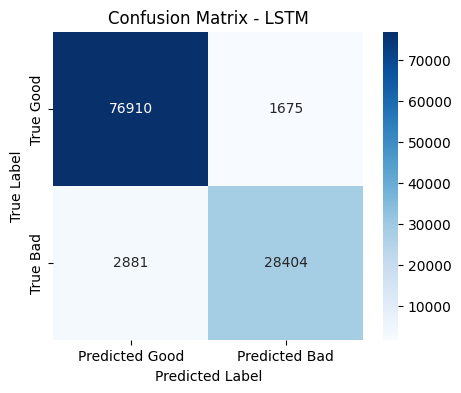

In [ ]:
# --- 1. Define the LSTM Model Architecture ---
lstm_model = Sequential([
    # Layer 1: Embedding. This layer is essential for all text-based models. It converts
    # the integer-encoded characters into dense vectors, allowing the model to learn
    # relationships between characters.
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM),

    # Layer 2: LSTM. This is the core recurrent layer. It processes the sequence of character
    # vectors one by one, using its internal gates (forget, input, output) to maintain a
    # "memory" of the important patterns it has seen so far.
    # 'units=64' defines the size of the hidden state/memory.
    LSTM(units=64),

    # Layer 3: Dropout. A regularization layer to prevent overfitting by randomly
    # dropping neuron connections during training.
    Dropout(0.5),

    # Layer 4: Dense. A standard fully connected layer that takes the features extracted
    # by the LSTM and learns to combine them for the final classification.
    Dense(32, activation='relu'),

    # Layer 5: Output Dense. The final output neuron with a sigmoid activation,
    # producing a probability score between 0 and 1 for our binary classification.
    Dense(1, activation='sigmoid')
])

# --- 2. Train and Evaluate the LSTM ---
lstm_result = train_and_evaluate_dl_model(lstm_model, "LSTM")

# --- 3. Add results to master list and visualize ---
all_results.append(lstm_result)
plot_confusion_matrix(lstm_result['confusion_matrix'], lstm_result['name'])



*   **1D Convolutional Neural Network (1D-CNN)**




--- Training 1D-CNN ---
Epoch 1/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8707 - loss: 0.2965 - val_accuracy: 0.9554 - val_loss: 0.1246
Epoch 2/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9464 - loss: 0.1474 - val_accuracy: 0.9611 - val_loss: 0.1053
Epoch 3/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9509 - loss: 0.1326 - val_accuracy: 0.9625 - val_loss: 0.1019
Epoch 4/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9547 - loss: 0.1240 - val_accuracy: 0.9662 - val_loss: 0.0944
Epoch 5/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9562 - loss: 0.1184 - val_accuracy: 0.9668 - val_loss: 0.0907

--- Evaluating 1D-CNN ---

Test Accuracy for 1D-CNN: 0.9668
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.97      0.99      0.98     78585
 bad (class 1)       0.97      0.91      0.94     31285

      accuracy             

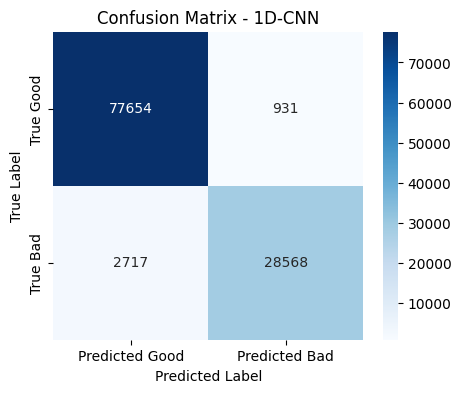

In [ ]:
# --- 1. Define the 1D-CNN Model Architecture ---
cnn_model = Sequential([
    # Layer 1: Embedding. Turns character integers into dense vectors of size EMBEDDING_DIM.
    # It's the essential first layer for any text-based deep learning model.
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM),

    # Layer 2: Conv1D. Scans the URL for local patterns using 128 different filters of size 5.
    # This is how the model learns to recognize important character sequences like 'login' or '.exe'.
    Conv1D(filters=128, kernel_size=5, activation='relu'),

    # Layer 3: GlobalMaxPooling1D. Reduces the output of the convolutional layer by taking the
    # single most important feature (the max value) from each filter.
    GlobalMaxPooling1D(),

    # Layer 4: Dropout. Randomly sets 50% of neuron activations to 0 during training
    # to prevent the model from becoming too specialized (overfitting).
    Dropout(0.5),

    # Layer 5: Dense. A standard fully connected layer with 64 neurons to learn higher-level combinations of features.
    Dense(64, activation='relu'),

    # Layer 6: Output Dense. A single neuron with a 'sigmoid' activation function, which outputs
    # a probability between 0 and 1, perfect for our binary (good/bad) classification task.
    Dense(1, activation='sigmoid')
])

# --- 2. Train and Evaluate the 1D-CNN ---
cnn_result = train_and_evaluate_dl_model(cnn_model, "1D-CNN")

# --- 3. Add results to master list and visualize ---
all_results.append(cnn_result)
plot_confusion_matrix(cnn_result['confusion_matrix'], cnn_result['name'])



*   **Bidirectional LSTM (Bi-LSTM)**




--- Training Bidirectional-LSTM ---
Epoch 1/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 51s 31ms/step - accuracy: 0.8364 - loss: 0.3708 - val_accuracy: 0.9283 - val_loss: 0.1892
Epoch 2/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.9299 - loss: 0.1873 - val_accuracy: 0.9393 - val_loss: 0.1588
Epoch 3/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9421 - loss: 0.1566 - val_accuracy: 0.9448 - val_loss: 0.1421
Epoch 4/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.9507 - loss: 0.1354 - val_accuracy: 0.9532 - val_loss: 0.1289
Epoch 5/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9579 - loss: 0.1173 - val_accuracy: 0.9621 - val_loss: 0.1077

--- Evaluating Bidirectional-LSTM ---

Test Accuracy for Bidirectional-LSTM: 0.9612
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.96      0.99      0.97     78585
 bad (class 1)       0.96      0.90      0

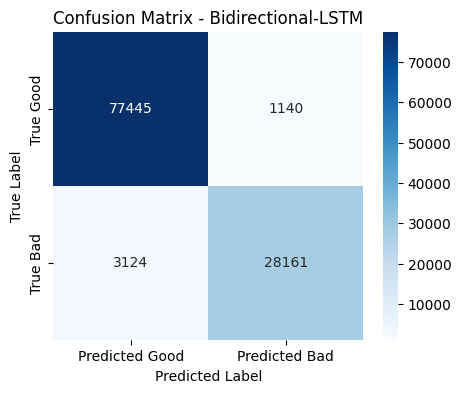

In [ ]:
# --- 1. Define the Bi-LSTM Model Architecture ---
bilstm_model = Sequential([
    # Layer 1: Embedding. Same as before, prepares the input for the recurrent layer.
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM),

    # Layer 2: Bidirectional LSTM. This processes the sequence forward and backward.
    # It helps the model understand context, e.g., how a word at the end relates to one at the start.
    # 'units=64' is the dimensionality of the memory state.
    Bidirectional(LSTM(units=64)),

    # Layer 3: Dropout. Prevents overfitting after the complex recurrent layer.
    Dropout(0.5),

    # Layer 4: Dense. A fully connected layer to interpret the features learned by the Bi-LSTM.
    Dense(32, activation='relu'),

    # Layer 5: Output Dense. The final sigmoid neuron for binary classification.
    Dense(1, activation='sigmoid')
])

# --- 2. Train and Evaluate the Bi-LSTM ---
bilstm_result = train_and_evaluate_dl_model(bilstm_model, "Bidirectional-LSTM")

# --- 3. Add results to master list and visualize ---
all_results.append(bilstm_result)
plot_confusion_matrix(bilstm_result['confusion_matrix'], bilstm_result['name'])



*   **Deeper 1D-CNN (2 Layers)**




--- Training Deeper 1D-CNN (2 Layers) ---
Epoch 1/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.8677 - loss: 0.3046 - val_accuracy: 0.9568 - val_loss: 0.1203
Epoch 2/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.9498 - loss: 0.1391 - val_accuracy: 0.9623 - val_loss: 0.1030
Epoch 3/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9583 - loss: 0.1164 - val_accuracy: 0.9684 - val_loss: 0.0891
Epoch 4/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9619 - loss: 0.1065 - val_accuracy: 0.9705 - val_loss: 0.0829
Epoch 5/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9643 - loss: 0.0994 - val_accuracy: 0.9722 - val_loss: 0.0785

--- Evaluating Deeper 1D-CNN (2 Layers) ---

Test Accuracy for Deeper 1D-CNN (2 Layers): 0.9711
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.97      0.99      0.98     78585
 bad (class 1)       0.96   

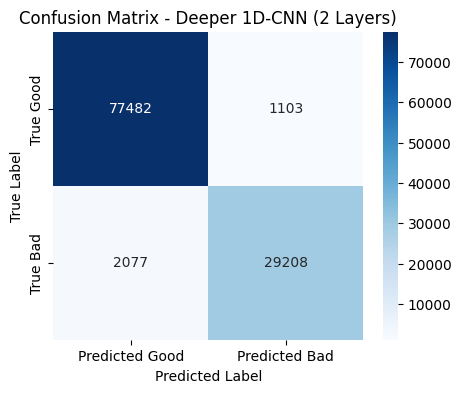

In [ ]:
# --- 1. Define the Deeper 1D-CNN Model Architecture ---
deep_cnn_model = Sequential([
    # Layer 1: Embedding. This remains the same, creating vector representations for each character.
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM),

    # --- Convolutional Block ---
    # Layer 2: First Conv1D. This layer learns low-level patterns, like important 3-5 character n-grams.
    # We use 'padding="same"' to ensure the output sequence has the same length as the input,
    # which is necessary before feeding it to the next convolutional layer.
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),

    # Layer 3: Second Conv1D. This layer takes the feature maps from the first Conv1D layer
    # and learns to combine the simple patterns into more complex ones.
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    # -------------------------

    # Layer 4: GlobalMaxPooling1D. After two layers of feature extraction, this layer
    # aggressively downsamples by taking the most important feature (the max value) from each filter.
    GlobalMaxPooling1D(),

    # Layer 5: Dropout. A crucial regularization step to prevent this more complex model
    # from overfitting to the training data.
    Dropout(0.5),

    # Layer 6: Dense. A fully connected layer that learns to combine the high-level features
    # for the final classification task.
    Dense(64, activation='relu'),

    # Layer 7: Output Dense. The final sigmoid neuron that outputs the probability of the
    # URL being malicious.
    Dense(1, activation='sigmoid')
])

# --- 2. Train and Evaluate the Deeper 1D-CNN ---
deep_cnn_result = train_and_evaluate_dl_model(deep_cnn_model, "Deeper 1D-CNN (2 Layers)")

# --- 3. Add results to master list and visualize ---
all_results.append(deep_cnn_result)
plot_confusion_matrix(deep_cnn_result['confusion_matrix'], deep_cnn_result['name'])

**Finding best threshold for better Recall**

In [ ]:
# Use your best DL model (e.g., the Deeper 1D-CNN)
# Get the raw probability predictions
y_pred_probs = deep_cnn_model.predict(X_test_dl)

# Try different thresholds
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for thresh in thresholds:
    y_pred_adj = (y_pred_probs > thresh).astype(int)
    print(f"\n--- Results for Threshold: {thresh} ---")
    print(classification_report(y_test_dl, y_pred_adj, target_names=['good', 'bad']))

3434/3434 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

--- Results for Threshold: 0.2 ---
              precision    recall  f1-score   support

        good       0.98      0.96      0.97     78585
         bad       0.91      0.96      0.94     31285

    accuracy                           0.96    109870
   macro avg       0.95      0.96      0.95    109870
weighted avg       0.96      0.96      0.96    109870


--- Results for Threshold: 0.3 ---
              precision    recall  f1-score   support

        good       0.98      0.97      0.98     78585
         bad       0.94      0.95      0.94     31285

    accuracy                           0.97    109870
   macro avg       0.96      0.96      0.96    109870
weighted avg       0.97      0.97      0.97    109870


--- Results for Threshold: 0.4 ---
              precision    recall  f1-score   support

        good       0.98      0.98      0.98     78585
         bad       0.95      0.94      0.95     31285

    accuracy                   

**Re-evaluate with new threshold function**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def re_evaluate_with_threshold(trained_model, model_name_base, threshold, X_test_data, y_test_data):
    """
    Re-evaluates a pre-trained Keras model using a new decision threshold.

    Args:
        trained_model (tf.keras.Model): The Keras model object that has already been trained.
        model_name_base (str): The base name of the model (e.g., "Deeper 1D-CNN").
        threshold (float): The new decision threshold to apply (e.g., 0.2).
        X_test_data (np.array): The test features.
        y_test_data (np.array): The true test labels.

    Returns:
        dict: A dictionary containing the model's performance metrics with the new threshold.
    """
    print(f"\n--- Re-evaluating: {model_name_base} with Threshold = {threshold} ---")

    # Step 1: Get raw probability predictions from the trained model.
    y_pred_probs = trained_model.predict(X_test_data)

    # Step 2: Apply the custom decision threshold to get new class labels.
    y_pred_adj = (y_pred_probs > threshold).astype(int)

    # Step 3: Calculate all metrics based on the adjusted predictions.
    report_adj = classification_report(y_test_data, y_pred_adj, target_names=['good (class 0)', 'bad (class 1)'])
    cm_adj = confusion_matrix(y_test_data, y_pred_adj)
    accuracy_adj = accuracy_score(y_test_data, y_pred_adj)

    print("\nAdjusted Classification Report:")
    print(report_adj)

    # Step 4: Package the new results into a dictionary with a descriptive name.
    result_dict = {
        'name': f'{model_name_base} (Th={threshold})',
        'accuracy': accuracy_adj,
        'report': report_adj,
        'confusion_matrix': cm_adj
    }

    return result_dict



*   **Deeper 1D-CNN with 0.2 Threshold**




--- Re-evaluating: Deeper 1D-CNN with Threshold = 0.2 ---
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Adjusted Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.98      0.96      0.97     78585
 bad (class 1)       0.91      0.96      0.94     31285

      accuracy                           0.96    109870
     macro avg       0.95      0.96      0.95    109870
  weighted avg       0.96      0.96      0.96    109870


'Deeper 1D-CNN (Th=0.2)' results have been added for final comparison.


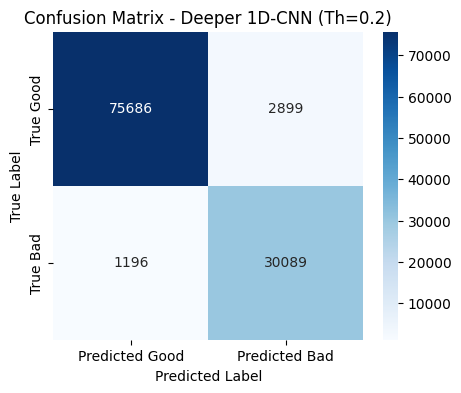

In [ ]:
# --- Evaluate Deeper 1D-CNN with 0.2 Threshold ---

# Assume 'deep_cnn_model' is your already trained model object.
# Assume 'all_results' is your master list.

# 1. Use the new function to get the adjusted results.
# We pass the trained model, its base name, the new threshold, and the test data.
adjusted_result = re_evaluate_with_threshold(
    trained_model=deep_cnn_model,
    model_name_base="Deeper 1D-CNN",
    threshold=0.2,
    X_test_data=X_test_dl,
    y_test_data=y_test_dl
)

# 2. Add the newly generated results to your master list.
all_results.append(adjusted_result)
print(f"\n'{adjusted_result['name']}' results have been added for final comparison.")

# 3. Use your existing plotting function to visualize the new confusion matrix.
plot_confusion_matrix(adjusted_result['confusion_matrix'], adjusted_result['name'])

* **Hybrid CNN-LSTM**


--- Training Hybrid CNN-LSTM ---
Epoch 1/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.7881 - loss: 0.4720 - val_accuracy: 0.9297 - val_loss: 0.1857
Epoch 2/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9373 - loss: 0.1710 - val_accuracy: 0.9530 - val_loss: 0.1319
Epoch 3/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9545 - loss: 0.1266 - val_accuracy: 0.9567 - val_loss: 0.1251
Epoch 4/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9623 - loss: 0.1066 - val_accuracy: 0.8866 - val_loss: 0.2803
Epoch 5/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9656 - loss: 0.0979 - val_accuracy: 0.9692 - val_loss: 0.0851

--- Evaluating Hybrid CNN-LSTM ---

Test Accuracy for Hybrid CNN-LSTM: 0.9699
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.97      0.99      0.98     78585
 bad (class 1)       0.98      0.92      0.95     3

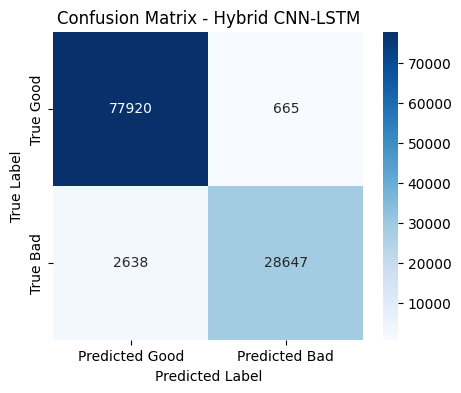

In [ ]:
# --- 1. Define the Hybrid CNN-LSTM Model Architecture ---
hybrid_model = Sequential([
    # Layer 1: Embedding. The standard input layer that converts character integers
    # into dense vectors, creating a meaningful representation for the model.
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM),

    # --- Feature Extraction Block (CNN) ---
    # Layer 2: Conv1D. This layer acts as the primary feature extractor. It scans the
    # URL for important local character patterns (n-grams) like 'login', '.exe', etc.
    # It learns to recognize these patterns regardless of their position.
    Conv1D(filters=64, kernel_size=5, activation='relu'),

    # --- Sequence Processing Block (LSTM) ---
    # Layer 3: LSTM. This layer takes the sequence of features detected by the CNN
    # and analyzes their order and context. It learns if the *sequence* of patterns
    # (e.g., a brand name pattern followed by a suspicious TLD pattern) is indicative of phishing.
    LSTM(units=64),

    # Layer 4: Dropout. A crucial regularization step to prevent this complex model from
    # overfitting by adding noise during training.
    Dropout(0.5),

    # --- Classifier Head ---
    # Layer 5: Dense. A final fully connected layer that takes the feature summary from the LSTM
    # and prepares it for the final classification decision.
    Dense(32, activation='relu'),

    # Layer 6: Output Dense. The single sigmoid neuron that outputs the final probability
    # score, determining if the URL is malicious (1) or benign (0).
    Dense(1, activation='sigmoid')
])

# --- 2. Train and Evaluate the Hybrid CNN-LSTM ---
hybrid_result = train_and_evaluate_dl_model(hybrid_model, "Hybrid CNN-LSTM")

# --- 3. Add results to master list and visualize ---
all_results.append(hybrid_result)
plot_confusion_matrix(hybrid_result['confusion_matrix'], hybrid_result['name'])

*  **Deeper 1D-CNN with Batch Normalization**


--- Training Deeper 1D-CNN + Batch Norm ---
Epoch 1/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.8154 - loss: 0.4477 - val_accuracy: 0.9443 - val_loss: 0.1565
Epoch 2/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9349 - loss: 0.1765 - val_accuracy: 0.9586 - val_loss: 0.1164
Epoch 3/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9489 - loss: 0.1410 - val_accuracy: 0.9611 - val_loss: 0.1065
Epoch 4/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9554 - loss: 0.1231 - val_accuracy: 0.9649 - val_loss: 0.0971
Epoch 5/5
1546/1546 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9591 - loss: 0.1125 - val_accuracy: 0.9675 - val_loss: 0.0928

--- Evaluating Deeper 1D-CNN + Batch Norm ---

Test Accuracy for Deeper 1D-CNN + Batch Norm: 0.9660
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Classification Report:
                precision    recall  f1-score   support

good (class 0)       0.96      0.99      0.98     78585
 bad (class 1)     

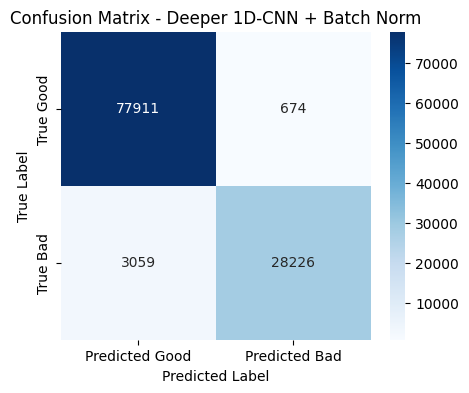

In [ ]:
# --- 1. Define the Deeper 1D-CNN with Batch Normalization ---
deep_cnn_bn_model = Sequential([
    # Layer 1: Embedding. Standard input layer for our text data.
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM),

    # --- First Convolutional Block with Batch Norm ---
    # Layer 2: Conv1D. Note that the activation='relu' has been removed.
    Conv1D(filters=64, kernel_size=3, padding='same'),

    # Layer 3: BatchNormalization. Normalizes the output of the previous layer.
    # It standardizes the inputs to the activation function to have a mean of 0 and std dev of 1.
    BatchNormalization(),

    # Layer 4: Activation. The ReLU activation is now applied as a separate layer.
    Activation('relu'),
    # -----------------------------------------------

    # --- Second Convolutional Block with Batch Norm ---
    # Layer 5: Second Conv1D layer.
    Conv1D(filters=128, kernel_size=5),

    # Layer 6: BatchNormalization.
    BatchNormalization(),

    # Layer 7: Activation.
    Activation('relu'),
    # -----------------------------------------------

    # Layer 8: GlobalMaxPooling1D. Reduces the feature maps to a single vector.
    GlobalMaxPooling1D(),

    # Layer 9: Dropout for regularization.
    Dropout(0.5),

    # Layer 10: Dense layer for high-level feature combination.
    Dense(64, activation='relu'),

    # Layer 11: Final output neuron.
    Dense(1, activation='sigmoid')
])

# --- 2. Train and Evaluate the new model ---
deep_cnn_bn_result = train_and_evaluate_dl_model(
    deep_cnn_bn_model,
    "Deeper 1D-CNN + Batch Norm"
)

# --- 3. Add results to master list and visualize ---
all_results.append(deep_cnn_bn_result)
plot_confusion_matrix(deep_cnn_bn_result['confusion_matrix'], deep_cnn_bn_result['name'])

# Hyperparameter tuning for Deeper 1D-CNN

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense

def model_builder(hp):
    """
    Builds a Deeper 1D-CNN model with tunable hyperparameters.
    This function is passed to the KerasTuner.
    """
    model = Sequential()

    # --- Define the search space for each hyperparameter ---

    # 1. Tune the Embedding dimension
    hp_embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=128, step=32)

    # 2. Tune the number of filters for the two Conv1D layers
    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    hp_filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)

    # 3. Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.6, step=0.1)

    # 4. Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    # --- Build the model using the hyperparameters from this trial ---
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=hp_embedding_dim))
    model.add(Conv1D(filters=hp_filters_1, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=hp_filters_2, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate=hp_dropout))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# --- Instantiate the Tuner ---
# Hyperband is an efficient algorithm that adaptively allocates resources.
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',  # Directory to store the tuning results
    project_name='phishing_deeper_cnn_tuning'
)

# --- Define an EarlyStopping callback ---
# This stops training a specific trial if the validation loss doesn't improve for 3 epochs.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("\n--- Starting Hyperparameter Search ---")
# The search method will run many trials to find the best model configuration.
tuner.search(
    X_train_dl, y_train_dl,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early]
)

# --- Retrieve the best hyperparameters ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n--- Hyperparameter Search Complete ---")
print(f"Optimal embedding dimension: {best_hps.get('embedding_dim')}")
print(f"Optimal filters in Conv1D layer 1: {best_hps.get('filters_1')}")
print(f"Optimal filters in Conv1D layer 2: {best_hps.get('filters_2')}")
print(f"Optimal dropout rate: {best_hps.get('dropout')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 11m 43s]
val_accuracy: 0.9786224365234375

Best val_accuracy So Far: 0.9822858572006226
Total elapsed time: 02h 16m 35s

--- Hyperparameter Search Complete ---
Optimal embedding dimension: 96
Optimal filters in Conv1D layer 1: 128
Optimal filters in Conv1D layer 2: 192
Optimal dropout rate: 0.3
Optimal learning rate: 0.001


In [ ]:
import json

# --- After tuner.search() is complete ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_params_dict = best_hps.values

# Define a path to save the JSON file
save_path = '/content/drive/MyDrive/colab_project_state/best_params.json'

# Write the dictionary to the file
with open(save_path, 'w') as f:
    json.dump(best_params_dict, f)

print(f"Optimal hyperparameters saved to: {save_path}")

# --- In a future session, you can load them back ---
# with open(save_path, 'r') as f:
#     loaded_params = json.load(f)
# print(loaded_params)

Optimal hyperparameters saved to: /content/drive/MyDrive/colab_project_state/best_params.json


# **Best Model - Deeper 1D-CNN with Optimal hyperparameters**


--- Building and training the final model with optimal parameters ---
Epoch 1/15
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.9259 - loss: 0.1895 - val_accuracy: 0.9685 - val_loss: 0.0886
Epoch 2/15
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - accuracy: 0.9662 - loss: 0.0956 - val_accuracy: 0.9740 - val_loss: 0.0732
Epoch 3/15
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.9716 - loss: 0.0803 - val_accuracy: 0.9736 - val_loss: 0.0717
Epoch 4/15
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - accuracy: 0.9748 - loss: 0.0702 - val_accuracy: 0.9778 - val_loss: 0.0635
Epoch 5/15
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.9772 - loss: 0.0645 - val_accuracy: 0.9798 - val_loss: 0.0588
Epoch 6/15
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - accuracy: 0.9793 - loss: 0.0588 - val_accuracy: 0.9787 - val_loss: 0.0604
Epoch 7/15
13734/13734 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - accuracy: 0.9800 - loss: 0.0562 - val_accuracy: 0.9810 - val_loss: 0.054

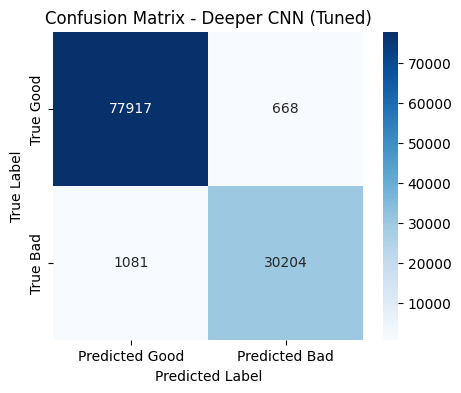

In [ ]:
# --- Train the Final Model Using the Best Hyperparameters ---

print("\n--- Building and training the final model with optimal parameters ---")

# 1. Retrieve the best hyperparameters found by the tuner.
# get_best_hyperparameters(num_trials=1)[0] returns the best HPs from the search.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# 2. Build a new model instance with these optimal hyperparameters.
# This ensures we are starting with a fresh, untrained model.
tuned_model = tuner.hypermodel.build(best_hps)

# 3. Train the final, tuned model on the entire training dataset.
# We train it for a sufficient number of epochs to let it converge properly.
# Using validation_data allows us to monitor performance on the test set during training.
history = tuned_model.fit(
    X_train_dl, y_train_dl,
    epochs=15, # Train for a few more epochs for the final model
    validation_data=(X_test_dl, y_test_dl),
    verbose=1
)

# --- Evaluate the Tuned Model and Add to Results ---
print("\n--- Evaluating the final tuned model and adding to results ---")

# We can now use this fully-trained model to get our final metrics.
# Get raw probability predictions
y_pred_probs = tuned_model.predict(X_test_dl)
# Convert probabilities to class labels (0 or 1) using the default 0.5 threshold
y_pred_tuned = (y_pred_probs > 0.5).astype(int)

# Calculate the final metrics
accuracy_tuned = accuracy_score(y_test_dl, y_pred_tuned)
report_tuned = classification_report(y_test_dl, y_pred_tuned, target_names=['good (class 0)', 'bad (class 1)'])
cm_tuned = confusion_matrix(y_test_dl, y_pred_tuned)

# Package the results into a dictionary with a descriptive name
tuned_result = {
    'name': 'Deeper CNN (Tuned)',
    'accuracy': accuracy_tuned,
    'report': report_tuned,
    'confusion_matrix': cm_tuned
}

# Append the final, tuned model's results to the master list
all_results.append(tuned_result)

print(f"\n'{tuned_result['name']}' results have been added for final comparison.")
print(f"Final Tuned Accuracy: {accuracy_tuned:.4f}")

# Visualize the confusion matrix of your best model
plot_confusion_matrix(tuned_result['confusion_matrix'], tuned_result['name'])

In [13]:
print("\nClassification Report: " + all_results[12]['name'])
print(all_results[12]['report'])


Classification Report: Deeper CNN (Tuned)
                precision    recall  f1-score   support

good (class 0)       0.99      0.99      0.99     78585
 bad (class 1)       0.98      0.97      0.97     31285

      accuracy                           0.98    109870
     macro avg       0.98      0.98      0.98    109870
  weighted avg       0.98      0.98      0.98    109870



# **Comparing models performance**

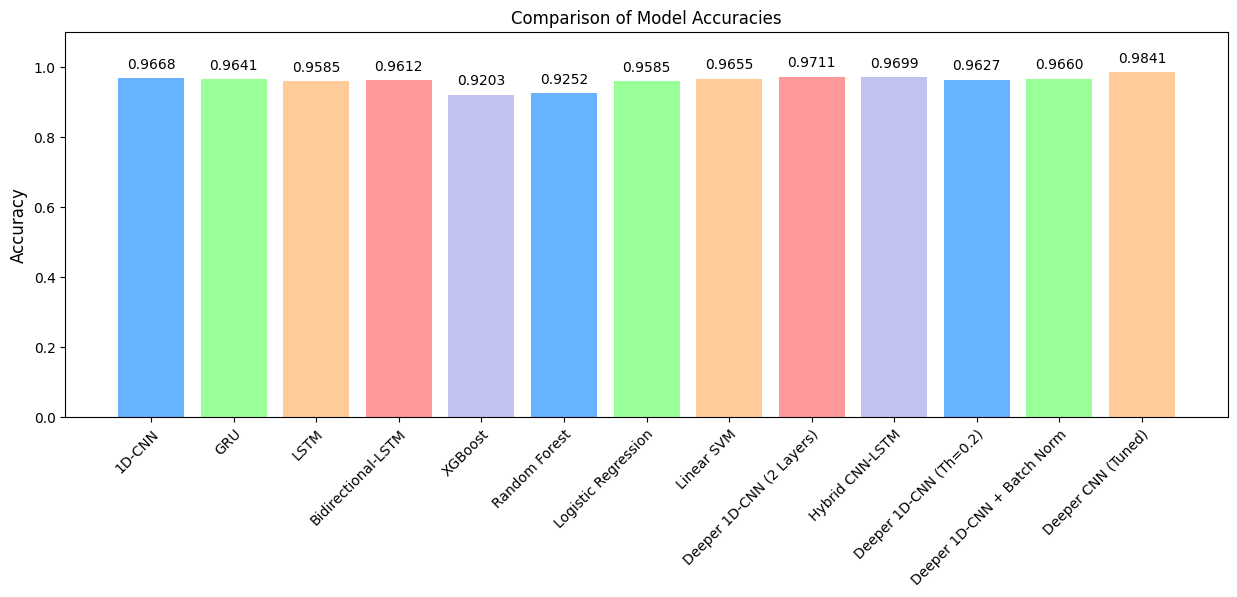

In [ ]:
# --- Final Performance Comparison Bar Chart ---

# Check if there are any results to plot
if not all_results:
    print("The 'all_results' list is empty. Please run one or more model cells before generating the comparison.")
else:
    # Extract model names and accuracies from the results
    model_names = [r['name'] for r in all_results]
    accuracies = [r['accuracy'] for r in all_results]

    plt.figure(figsize=(15, 5))
    bars = plt.bar(model_names, accuracies, color=['#66b3ff', '#99ff99', '#ffcc99', '#ff9999', '#c2c2f0'])
    plt.xticks(
    rotation=45,          # Rotates the labels by 45 degrees
    ha='right',           # Aligns the end of the label to the tick
    rotation_mode='anchor'
    )
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Comparison of Model Accuracies', fontsize=12)
    plt.ylim(0, 1.1)

    # Add accuracy values on top of each bar for clarity
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom')

    plt.show()